In [8]:
import SimpleITK as sitk
import numpy as np
import cv2
import os
import random
import shutil
import re
from ultralytics import YOLO

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


train_results = pd.read_csv('../radiological_gradings.csv')
train_results = train_results.loc[:, ['Patient','IVD label','Pfirrman grade']]
train_results


pfirrman_map = {
    (row.Patient, row["IVD label"]): row["Pfirrman grade"]
    for _, row in train_results.iterrows()
}



patient_id = 237
img_path = f"../images/{patient_id}_t2.mha"
mask_path = f"../masks/{patient_id}_t2.mha"

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

arr_img = sitk.GetArrayFromImage(sitk_img)  # shape: [H, W, slices]
arr_mask = sitk.GetArrayFromImage(sitk_mask)

print("Obraz:", arr_img.shape, "Maska:", arr_mask.shape)


Obraz: (495, 516, 18) Maska: (495, 516, 18)


In [9]:

VAL_DIR = "SPIDER_training_margin5_patient_split/train"
MODEL_PATH = "best_yolo.pt"

model = YOLO(MODEL_PATH)


In [10]:
import numpy as np
import SimpleITK as sitk
import os

def get_disc_dimensions(mask_path, image_path=None):

    mask_itk = sitk.ReadImage(mask_path)
    mask_np = sitk.GetArrayFromImage(mask_itk)  
    
    if image_path and os.path.exists(image_path):
        image_itk = sitk.ReadImage(image_path)
        spacing = image_itk.GetSpacing() 
    else:
        spacing = mask_itk.GetSpacing()
        if spacing[0] == 1.0 and spacing[1] == 1.0 and spacing[2] == 1.0:
            spacing = (0.5, 0.5, 3.0)  
    
    print(f"Spacing: x={spacing[0]:.2f}, y={spacing[1]:.2f}, z={spacing[2]:.2f} mm")
    
    disc_ids = np.unique(mask_np)
    disc_ids = disc_ids[disc_ids != 0]
    
    results = {}
    
    for disc_id in disc_ids:
        if disc_id >=201 and disc_id <=205:
            disc_mask = (mask_np == disc_id)
            
            z_indices, y_indices, x_indices = np.where(disc_mask)
            
            if len(z_indices) == 0:
                continue
            
            z_min, z_max = z_indices.min(), z_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()
            x_min, x_max = x_indices.min(), x_indices.max()
            

            depth_mm = (z_max - z_min + 1) * spacing[2]
            width_mm = (x_max - x_min + 1) * spacing[0]
            height_mm = (y_max - y_min + 1) * spacing[1]
            
            volume_voxels = np.sum(disc_mask)
            volume_mm3 = volume_voxels * spacing[0] * spacing[1] * spacing[2]
            
            results[disc_id] = {
                'depth_mm': round(depth_mm, 2),
                'width_mm': round(width_mm, 2),
                'height_mm': round(height_mm, 2),
                'voxel_count': volume_voxels,
                'z_slices': z_max - z_min + 1
            }
            
        
    return results



In [26]:
def preds(patient_id):
    BASE_DIR = "SPIDER_training_margin5_patient_split"
    VAL_DIRS = ["train", "val"]
    MODEL_PATH = "best_yolo.pt"

    model = YOLO(MODEL_PATH)
    patient_id_str = str(patient_id)

    TARGET_DISKS = {201, 202, 203, 204, 205}
    found_disks = set()
    images_info = []  

    for split in VAL_DIRS:
        split_dir = os.path.join(BASE_DIR, split)

        if not os.path.isdir(split_dir):
            continue

        for grade_folder in os.listdir(split_dir):
            grade_path = os.path.join(split_dir, grade_folder)

            if not os.path.isdir(grade_path) or not grade_folder.startswith("grade"):
                continue

            try:
                grade = int(grade_folder.replace("grade", ""))
            except ValueError:
                continue

            for img_file in os.listdir(grade_path):
                if not img_file.startswith(f"patient{patient_id_str}_") or not img_file.endswith(".png"):
                    continue

                disk_match = re.search(r'disk(\d+)', img_file)
                if not disk_match:
                    continue

                disk_num = int(disk_match.group(1))

                if disk_num not in TARGET_DISKS:
                    continue

                if disk_num in found_disks:
                    continue

                found_disks.add(disk_num)
                images_info.append(
                    (os.path.join(grade_path, img_file), grade, disk_num)
                )

    if not images_info:
        print(f"No images found for patient {patient_id}")
        return []

    images_info.sort(key=lambda x: x[2])
    predictions = []

    for img_path, grade, disk_num in images_info:
        try:
            results = model.predict(img_path, verbose=False, save=False)
            if results and hasattr(results[0], "probs") and results[0].probs is not None:
                pred_class = int(results[0].probs.top1) + 1
            else:
                pred_class = 0
        except Exception as e:
            print(f"Error {os.path.basename(img_path)}: {e}")
            pred_class = 0

        predictions.append(pred_class)

    print(f"Predictions for patient {patient_id}: {predictions}")
    return predictions


In [29]:
def show_disc(img_slice, mask_slice, patient_id=237, size=128):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    disc_ids = [201, 202, 203, 204, 205]

    mask_path = f"SPIDER_cleaned/masks/{patient_id}_t2.mha"
    image_path = f"SPIDER_cleaned/images/{patient_id}_t2.mha"

    
    dimensions = get_disc_dimensions(mask_path, image_path)
        

    img_rgb = cv2.cvtColor(
        cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8),
        cv2.COLOR_GRAY2BGR
    )

    bboxes = {}

    # --- bboxy ---
    for did in disc_ids:
        ys, xs = np.where(mask_slice == did)
        if len(xs) == 0:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        bboxes[did] = (x_min, x_max, y_min, y_max)

        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img_rgb, str(did), (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    n_discs = len(bboxes)
    fig, axes = plt.subplots(
        2, 1 + n_discs,
        figsize=(4 * (1 + n_discs), 9),
        gridspec_kw={"height_ratios": [1, 0.6]}
    )

    preds_res = preds(patient_id)

    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title("Whole spine")
    axes[0, 0].axis("off")

    for i, (did, (x_min, x_max, y_min, y_max)) in enumerate(bboxes.items()):
        disc_crop = img_slice[y_min:y_max+1, x_min:x_max+1]
        disc_norm = 255.0 * (disc_crop - disc_crop.min()) / (disc_crop.max() - disc_crop.min() + 1e-6)
        disc_norm = disc_norm.astype(np.uint8)
        disc_resized = cv2.resize(disc_norm, (size, size))

        axes[0, i + 1].imshow(disc_resized, cmap="gray")
        axes[0, i + 1].set_title(f"Disc {did}")
        axes[0, i + 1].axis("off")


    for j in range(1 + n_discs):
        axes[1,j].axis("off")
    for i, (did, dims) in enumerate(dimensions.items()):
        text = (f"Disc {did}\n"
                f"Depth: {dims['depth_mm']:.1f} mm\n"
                f"Width: {dims['width_mm']:.1f} mm\n"
                f"Height: {dims['height_mm']:.1f} mm\n"
                f"Prediction: Grade: {preds_res[i]}")
        axes[1, i + 1].text(0.5, 0.5, text, fontsize=12, ha='center', va='center')
    plt.suptitle(f"Patient {patient_id} - Information table")

    plt.tight_layout()
    plt.show()

Spacing: x=4.40, y=0.60, z=0.62 mm
Predictions for patient 237: [1, 1, 1, 1, 1]


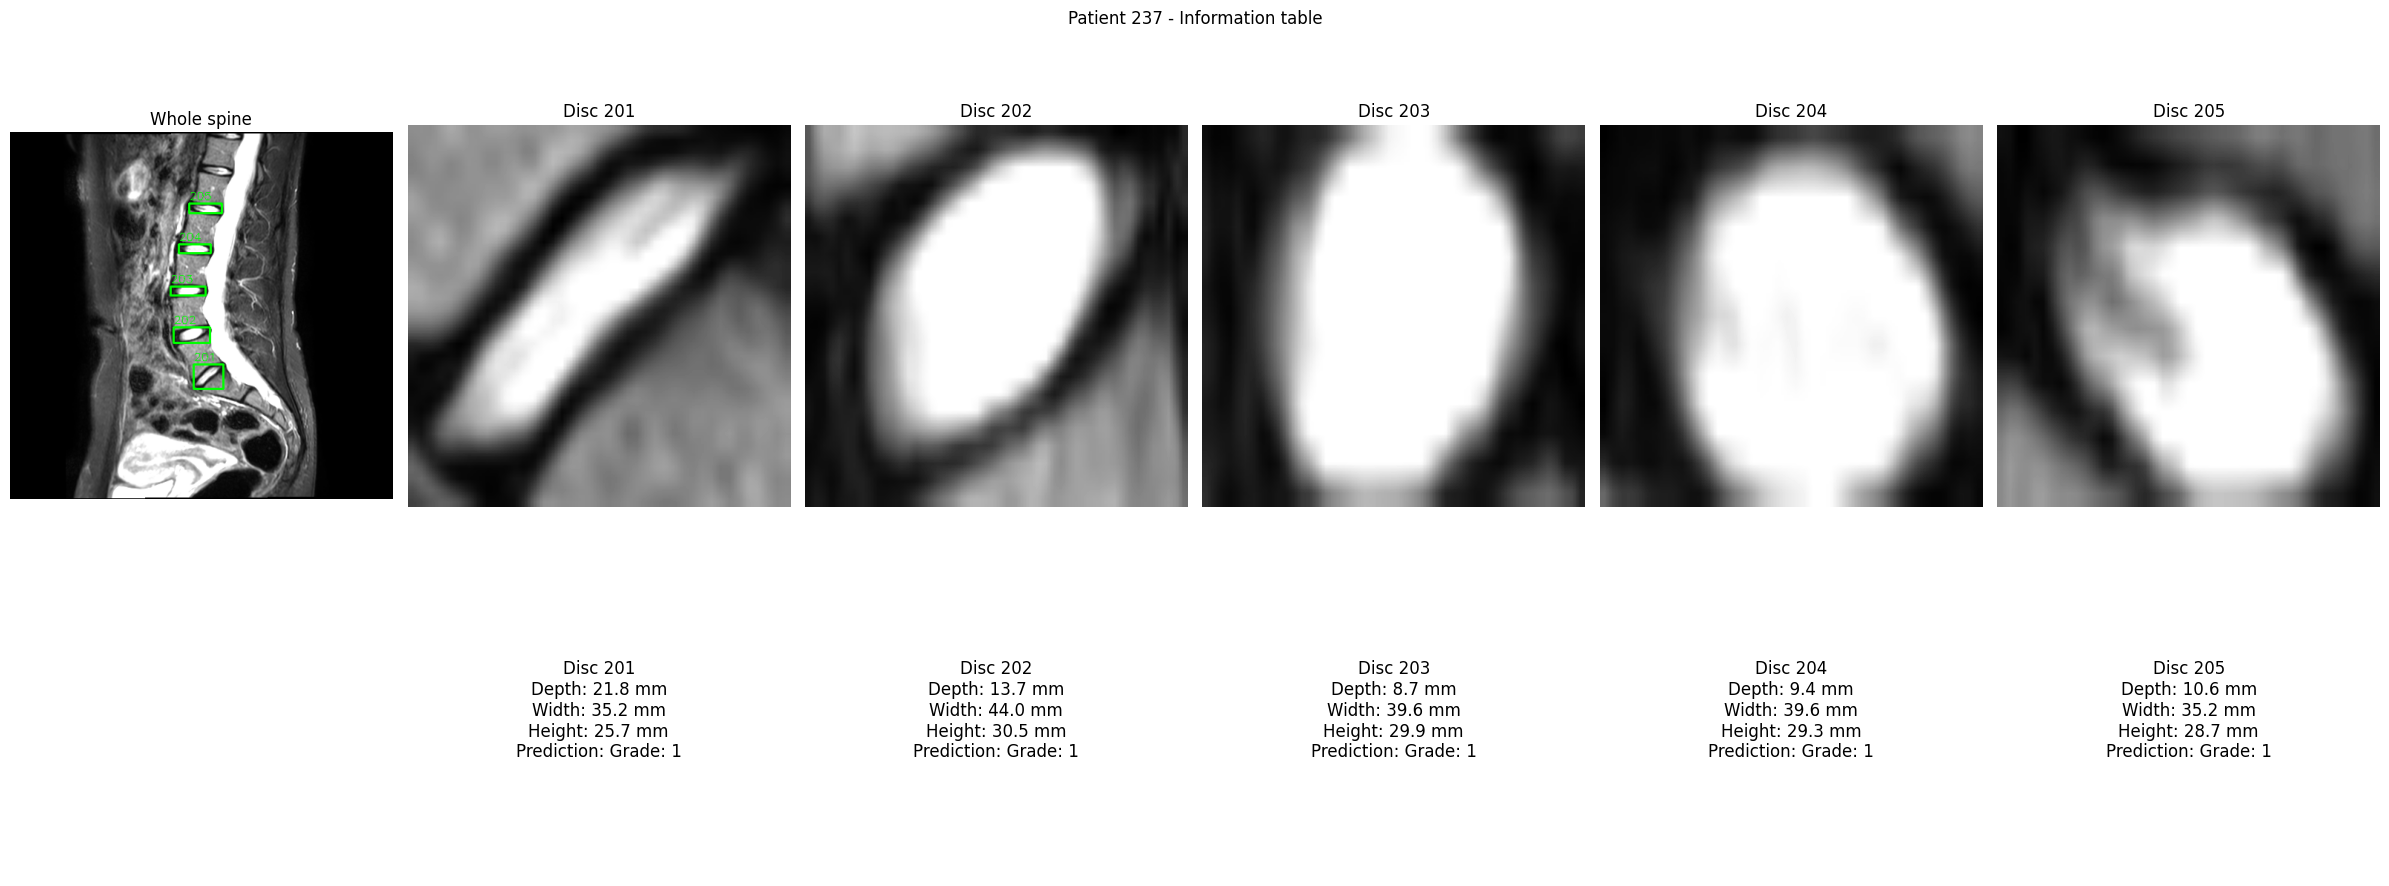

In [30]:
mid = arr_img.shape[2] // 2
slices_to_take = [mid-1, mid, mid+1]
patient_id = 237

img_slice = np.flipud(arr_img[:, :, slices_to_take[1]])
mask_slice = np.flipud(arr_mask[:, :, slices_to_take[1]])


show_disc(img_slice, mask_slice, patient_id)
